# Kaggle Titanic
[Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview)

# Setup

In [1]:
%%html
<style>
row {float:left}
</style>

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import scipy as sp
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)
np.set_printoptions(
    suppress=True #, formatter={'float_kind':'{:0.5f}'.format}
)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
%%html
<!-- To left align the HTML components in Markdown -->
<style>
table {float:left}
</style>

# Constants

In [4]:
# Total percentage of the information in the data to preserve after reducing the dimensions
COVERAGE = 0.95

# Number of classes / neighbours to classify
NUM_CLASSES=10

PROTOCOL = "file://"
DATA_DIR = "/data/kaggle/titanic"

## Loading Data

| Feature  | Desription  |Value|
|:---|:---|:---|
|Pclass|Passenger Class|1 = 1st, 2 = 2nd, 3 = 3rd|
|Ticket|Ticket Number| |
|SibSp|# of siblings / spouses aboard the Titanic||
|Parch|# of parents / children aboard the Titanic|   |
|Embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

In [5]:
numerical_columns = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_columns = ['Sex', 'Pclass', 'Embarked']
drop_columns = ['PassengerId', 'Ticket', 'Cabin', 'Name']

In [6]:
X_train = pd.read_csv(
    PROTOCOL + DATA_DIR + "/train.csv.gz",
    compression = "gzip",
    sep = ","
#    usecols = lambda column : column not in ["Survived"]
)
print(X_train.shape)
X_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Unique values

In [7]:
print("Embarked values = {}".format(X_train['Embarked'].dropna().unique()))
print("Pclass values = {}".format(X_train['Pclass'].dropna().unique()))
print("Gender values = {}".format(X_train['Sex'].dropna().unique()))
print("Sib/Sp values = {}".format(X_train['SibSp'].dropna().unique()))
print("Par/Ch values = {}".format(X_train['Parch'].dropna().unique()))

Embarked values = ['S' 'C' 'Q']
Pclass values = [3 1 2]
Gender values = ['male' 'female']
Sib/Sp values = [1 0 3 4 2 5 8]
Par/Ch values = [0 1 2 5 3 4 6]


# Inspect raw data

In [8]:
X_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
X_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_pipeline = ColumnTransformer([
    ("categorical", OrdinalEncoder(), categorical_columns + ['Survived'])
])

X_train_categories = pd.DataFrame(
    categorical_pipeline.fit_transform(
        X_train[categorical_columns+ ['Survived']].fillna(method='ffill')
    ),
    columns=categorical_columns+ ['Survived']
)
X_inspect = X_train[numerical_columns].merge(
    X_train_categories,
    left_index=True,
    right_index=True
)
X_inspect.head()

,Age,Fare,SibSp,Parch,Sex,Pclass,Embarked,Survived
0,22.0,7.2500,1,0,1.0,2.0,2.0,0.0
1,38.0,71.2833,1,0,0.0,0.0,0.0,1.0
2,26.0,7.9250,0,0,0.0,2.0,2.0,1.0
3,35.0,53.1000,1,0,0.0,0.0,2.0,1.0
4,35.0,8.0500,0,0,1.0,2.0,2.0,0.0


In [12]:
X_inspect_survived = X_inspect[X_inspect['Survived'] == 1]
X_inspect_dead = X_inspect[X_inspect['Survived'] == 0]

X_inspect_male = X_inspect[X_inspect['Sex'] == 1]
X_inspect_female = X_inspect[X_inspect['Sex'] == 0]
X_inspect_male_age = X_inspect_male['Age']
X_inspect_female_age = X_inspect_female['Age']

([array([14.,  9.,  1.,  4.,  5.,  4.,  2., 12., 20., 31., 33., 25., 32.,
         30., 29., 26., 21., 26., 12., 15., 14.,  9., 11., 12.,  9., 10.,
          5.,  5.,  3.,  5.,  6.,  2.,  4.,  0.,  2.,  3.,  1.,  0.,  0.,
          1.]),
  array([24., 16.,  7.,  7., 10.,  5.,  8., 23., 39., 40., 52., 46., 42.,
         43., 47., 37., 32., 41., 18., 27., 21., 14., 17., 18., 16., 13.,
          9.,  7.,  7.,  6.,  7.,  4.,  4.,  0.,  2.,  3.,  1.,  0.,  0.,
          1.])],
 array([ 0.42  ,  2.4095,  4.399 ,  6.3885,  8.378 , 10.3675, 12.357 ,
        14.3465, 16.336 , 18.3255, 20.315 , 22.3045, 24.294 , 26.2835,
        28.273 , 30.2625, 32.252 , 34.2415, 36.231 , 38.2205, 40.21  ,
        42.1995, 44.189 , 46.1785, 48.168 , 50.1575, 52.147 , 54.1365,
        56.126 , 58.1155, 60.105 , 62.0945, 64.084 , 66.0735, 68.063 ,
        70.0525, 72.042 , 74.0315, 76.021 , 78.0105, 80.    ]),
 <a list of 2 Lists of Patches objects>)

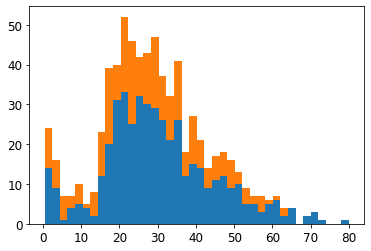

In [13]:
plt.hist(
    [
        X_inspect_male_age.values,
        X_inspect_female_age.values
    ],
    bins=40,
    stacked=True
)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34107dc0b8>,
      dtype=object)

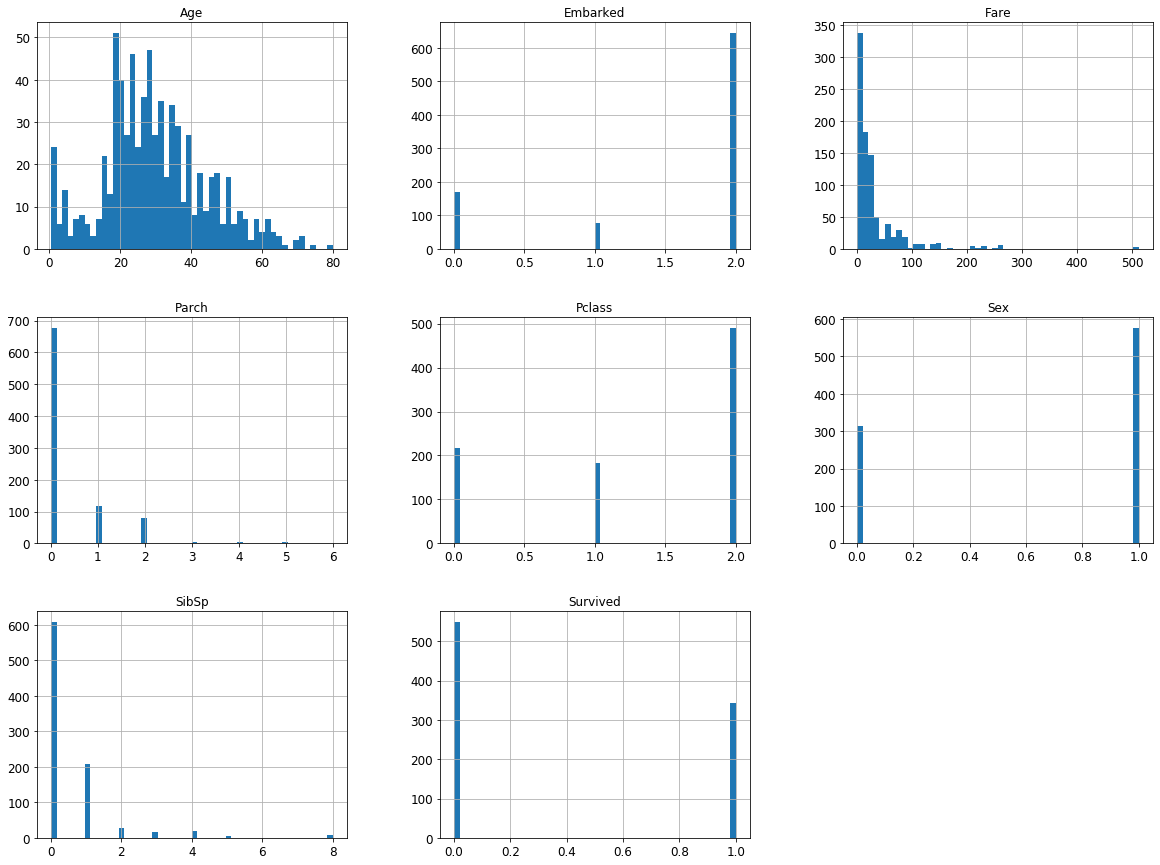

In [14]:
X_inspect.hist(bins=50, figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f340fa3fb00>,
      dtype=object)

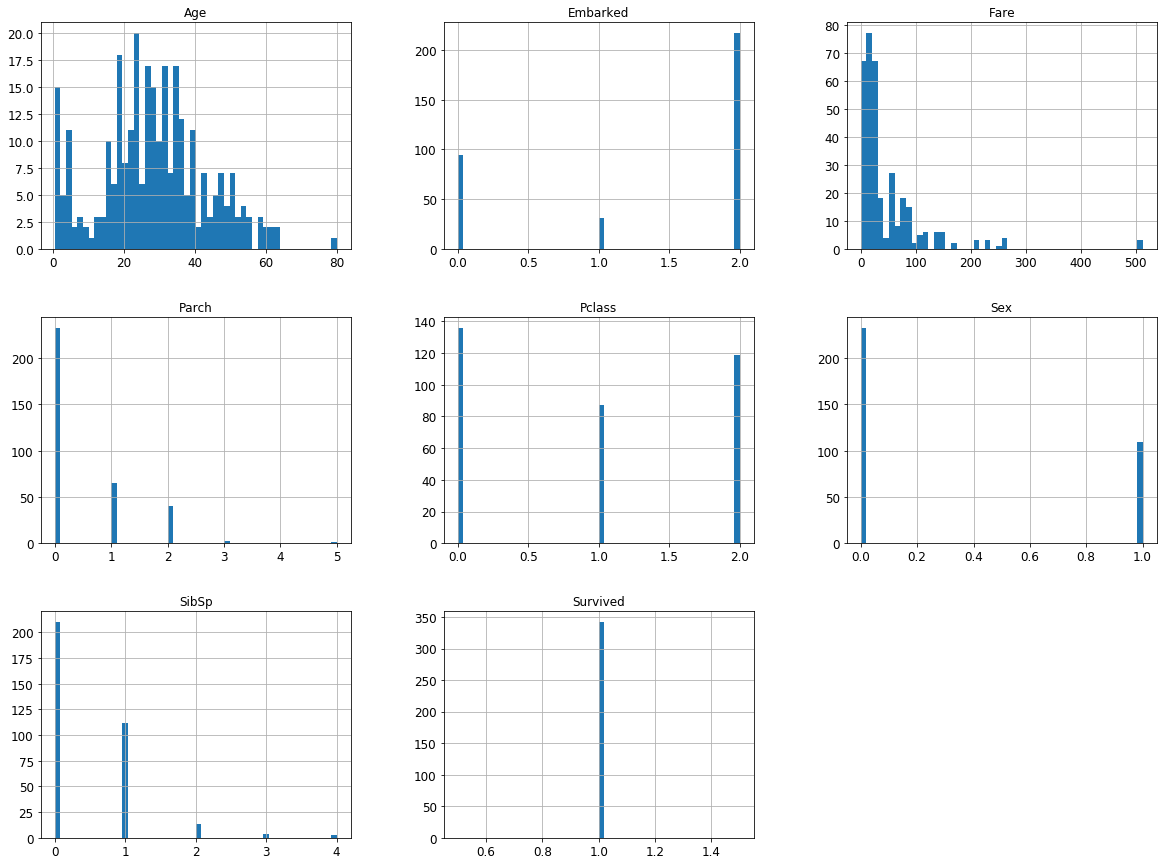

In [15]:
X_inspect_survived.hist(bins=50, figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f340f52d208>,
      dtype=object)

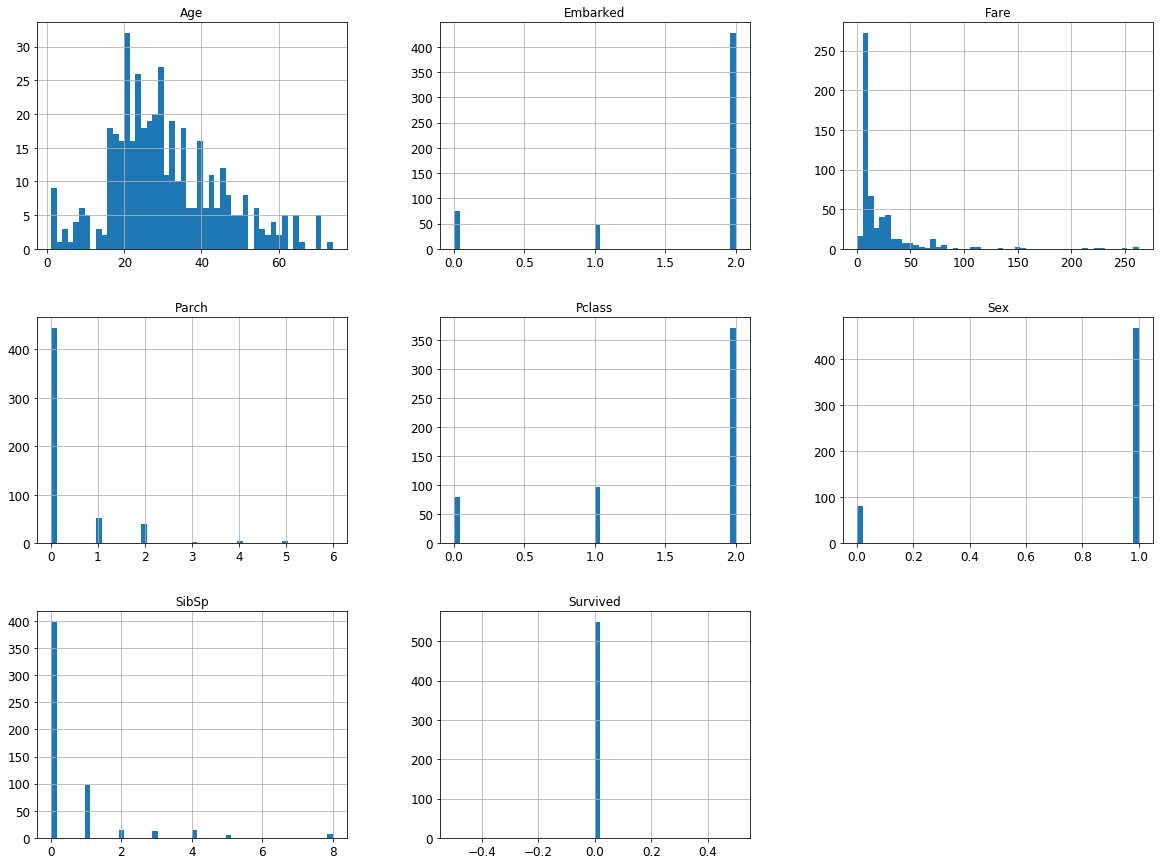

In [16]:
X_inspect_dead.hist(bins=50, figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f340eda1f60>,
      dtype=object)

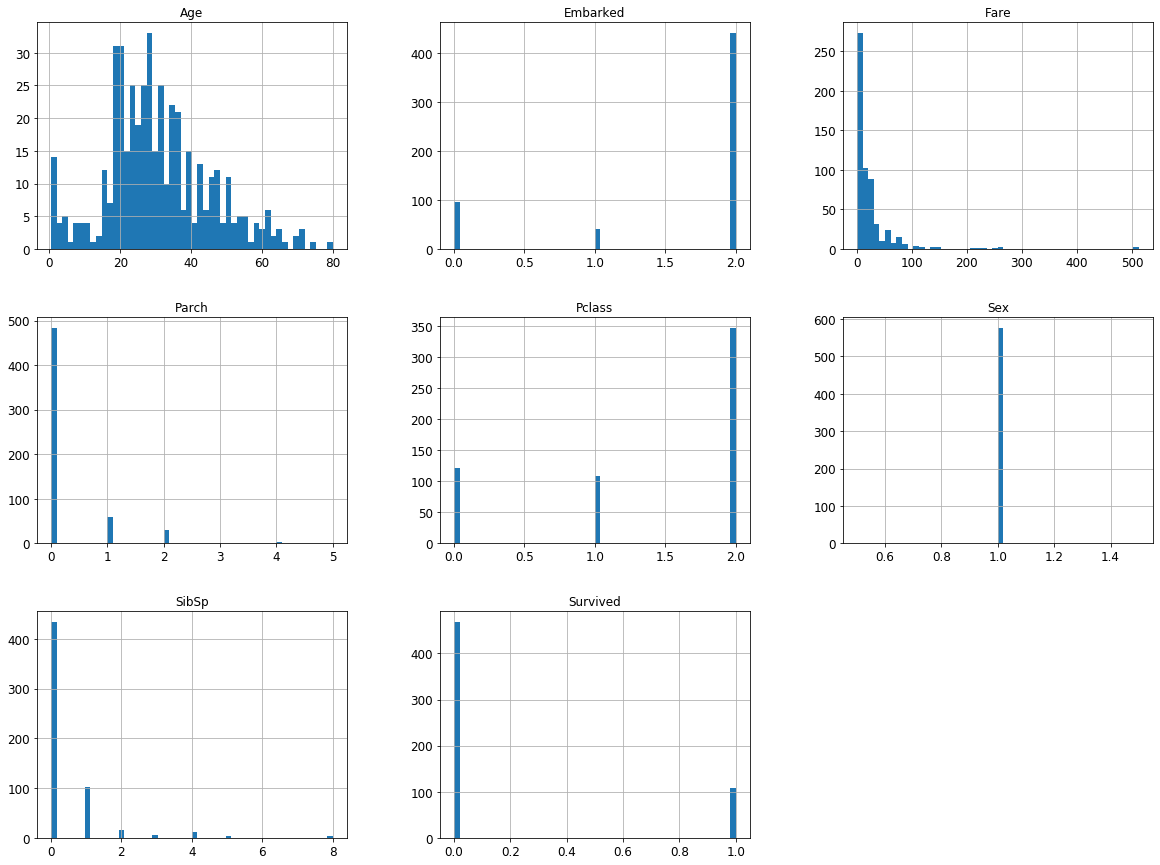

In [17]:
X_inspect_male.hist(bins=50, figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f340e66a7f0>,
      dtype=object)

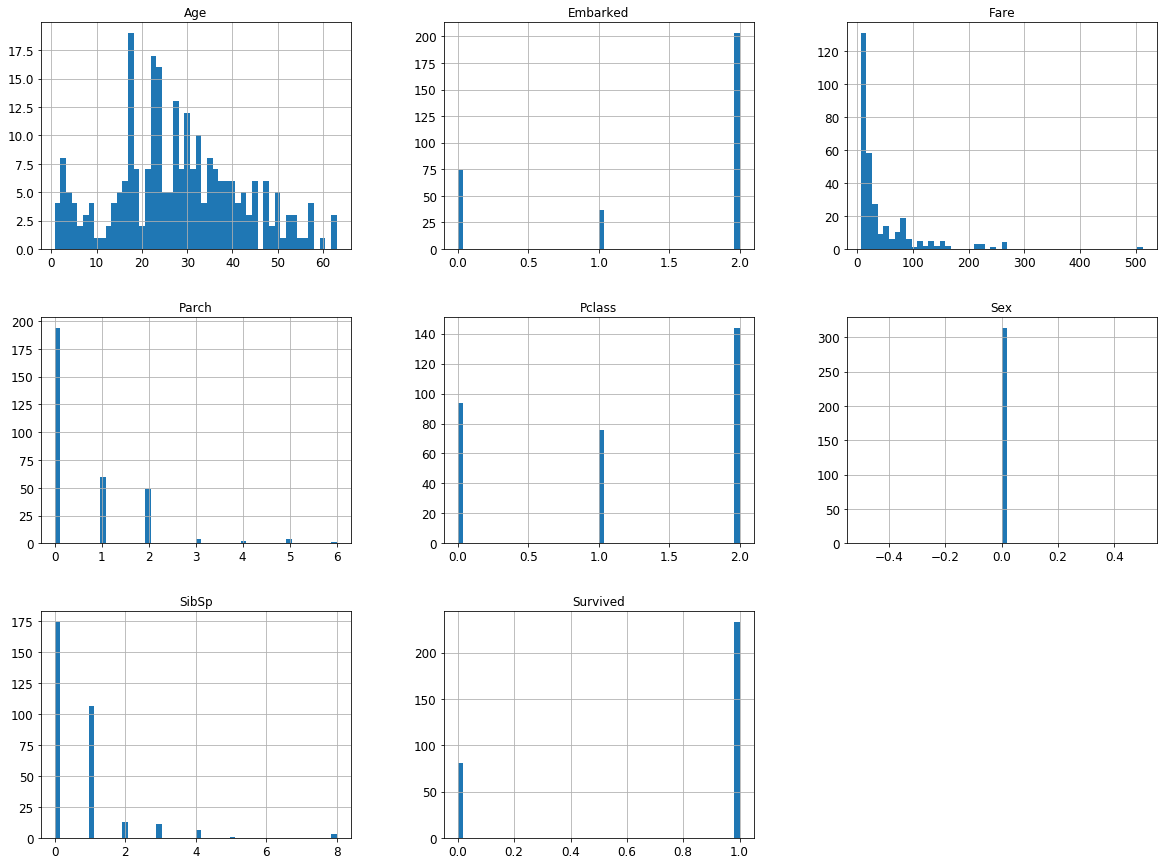

In [18]:
X_inspect_female.hist(bins=50, figsize=(20,15))

/home/oonisim/conda/envs/jupyter-notebook/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/oonisim/conda/envs/jupyter-notebook/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/oonisim/conda/envs/jupyter-notebook/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/oonisim/conda/envs/jupyter-notebook/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


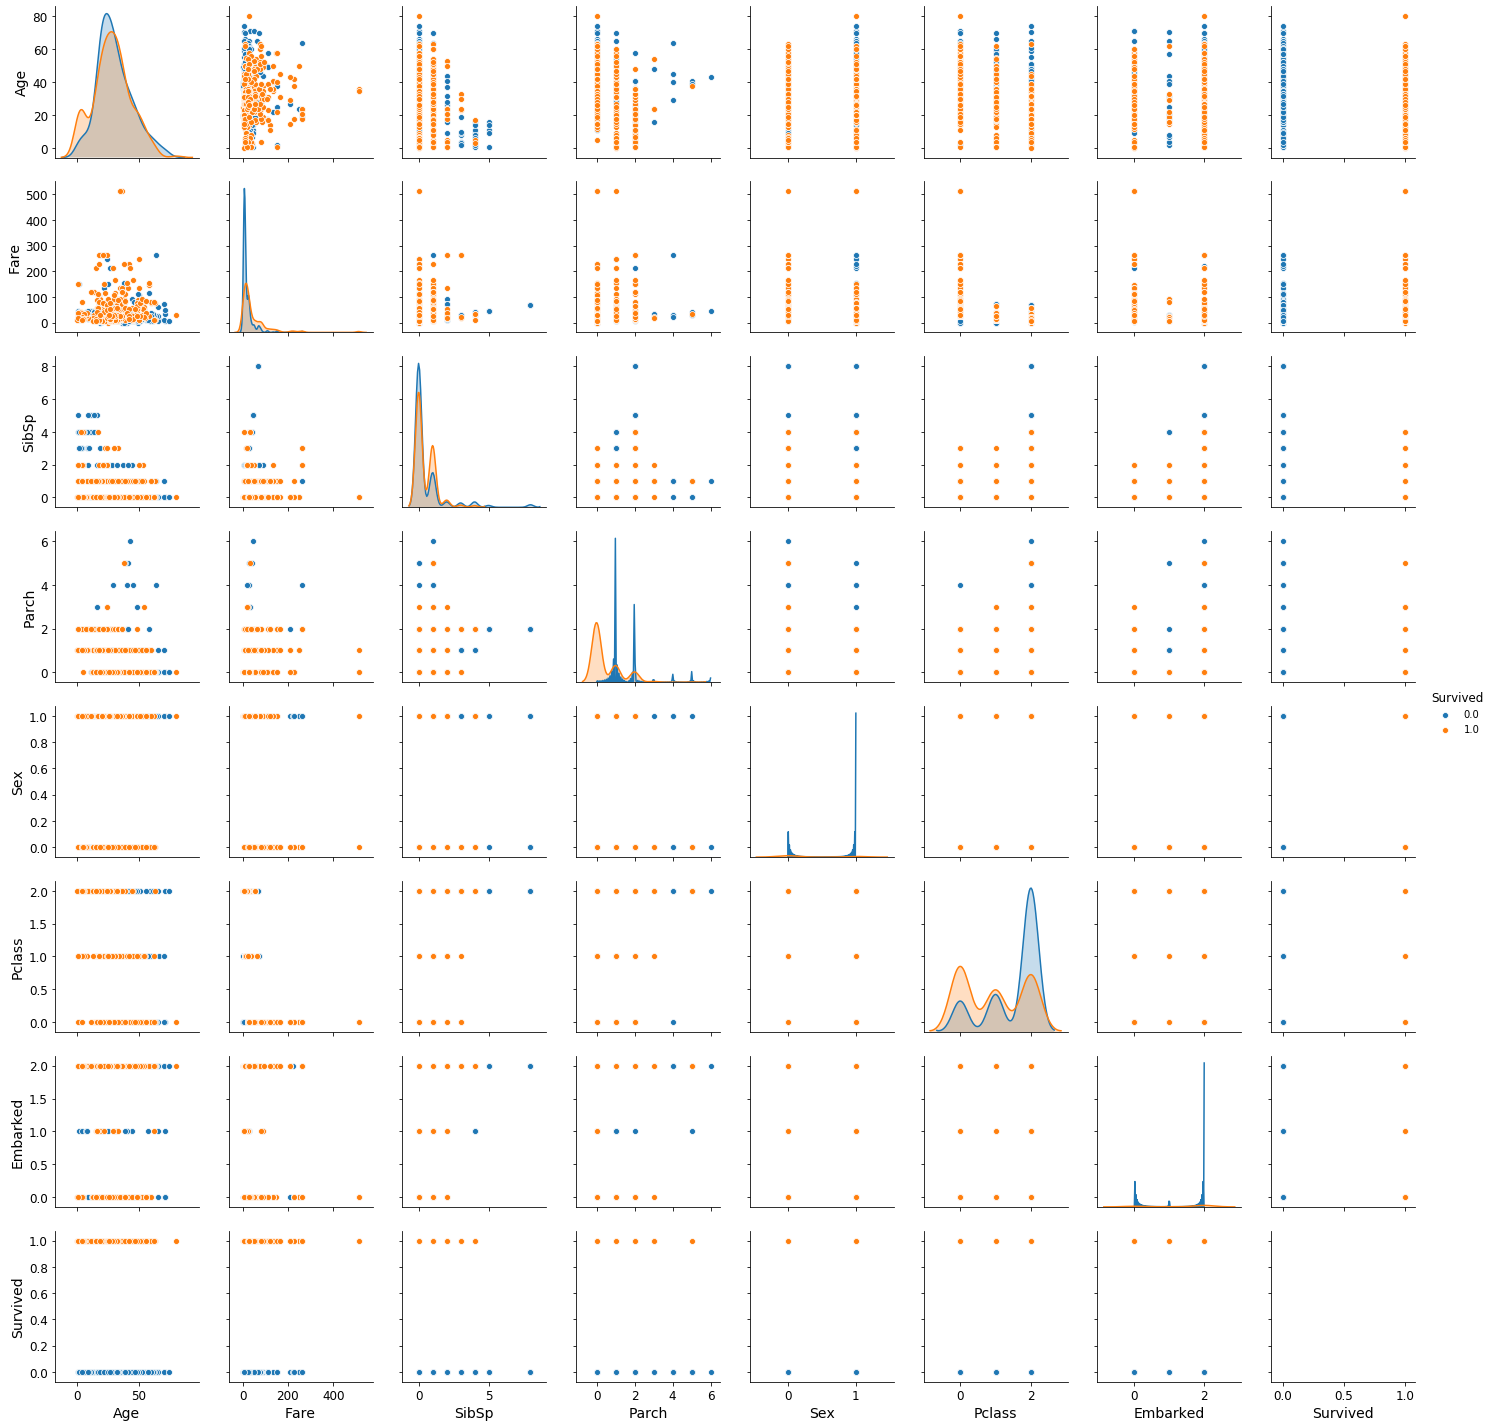

In [19]:
sns.pairplot(data=X_inspect, hue="Survived")

## Primary features of survived

In [20]:
X_train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


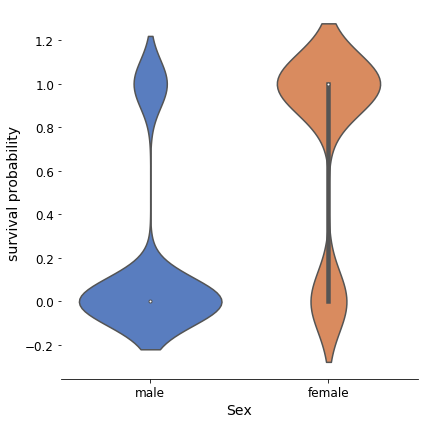

In [21]:
g = sns.catplot(x="Sex", y="Survived", data=X_train,
                height=6, kind="violin", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

## Passenger Class

In [22]:
X_train[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


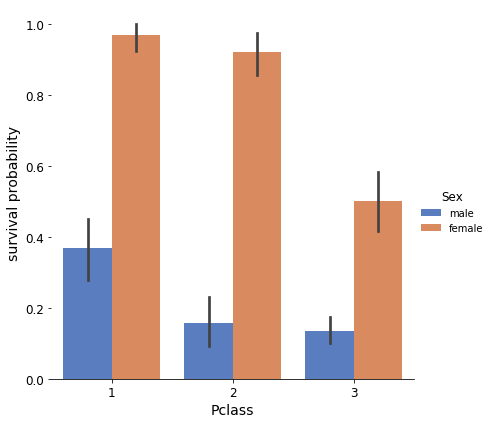

In [23]:
g = sns.catplot(x="Pclass", y="Survived", hue='Sex', data=X_train,
                height=6, kind="violin", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

In [24]:
X_train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [25]:
X_train[["Sex", "Embarked", "Survived"]].groupby(["Sex", 'Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Embarked,Survived
0,female,C,0.876712
1,female,Q,0.750000
2,female,S,0.689655
3,male,C,0.305263
5,male,S,0.174603
4,male,Q,0.073171


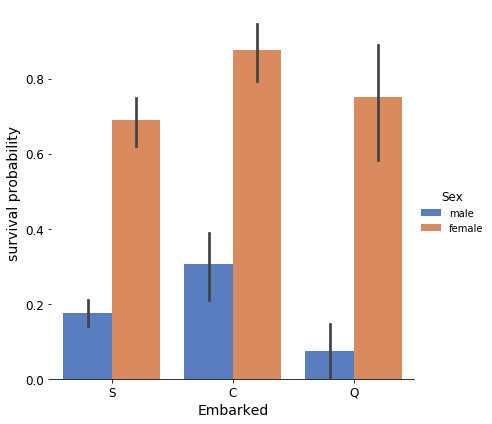

In [26]:
g = sns.catplot(x="Embarked", y="Survived", hue="Sex", data=X_train,
                height=6, kind="violin", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

In [27]:
X_train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


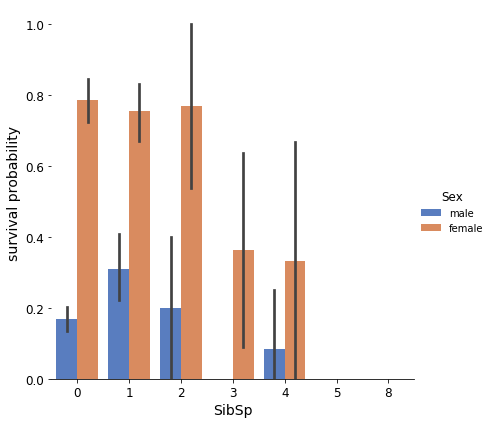

In [28]:
g = sns.catplot(x="SibSp", y="Survived", hue='Sex', data=X_train,
                height=6, kind="violin", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

In [29]:
X_train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


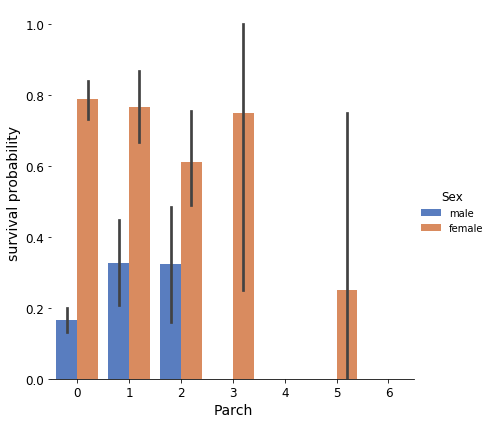

In [30]:
g = sns.catplot(x="Parch", y="Survived", hue='Sex', data=X_train,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

# Main

## Label
If the passenger survived or not

In [31]:
y_train = pd.read_csv(
    PROTOCOL + DATA_DIR + "/train.csv.gz",
    compression = "gzip",
    sep = ",",
    usecols = lambda column : column in ["Survived"],
)
print(y_train.shape)
y_train.head()

(891, 1)


,Survived
0,0
1,1
2,1
3,1
4,0


## Test data

In [32]:
X_test = pd.read_csv(
    PROTOCOL + DATA_DIR + "/test.csv.gz",
    compression = "gzip",
    sep = ","
)
print(X_test.shape)
X_test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [33]:
print("Embarked values = {}".format(X_test['Embarked'].dropna().unique()))
print("Pclass values = {}".format(X_test['Pclass'].dropna().unique()))
print("Gender values = {}".format(X_test['Sex'].dropna().unique()))
print("Sib/Sp values = {}".format(X_test['SibSp'].dropna().unique()))
print("Par/Ch values = {}".format(X_test['Parch'].dropna().unique()))

Embarked values = ['Q' 'S' 'C']
Pclass values = [3 2 1]
Gender values = ['male' 'female']
Sib/Sp values = [0 1 2 3 4 5 8]
Par/Ch values = [0 1 3 2 4 6 5 9]


In [34]:
def concat(df1, df2):
    return df1.append(df2, ignore_index=True)

# Data cleaning

## Embark
Embarkment location is the important feature. Fill the NA value with Forward Fill.

In [35]:
X_train['Embarked'] = X_train['Embarked'].fillna(method='ffill')

## Fare

In [36]:
X_test['Fare'] = X_test['Fare'].fillna(method='ffill')

## Age
Train a random forest to predict age from other features.

In [37]:
# Get data sets where age/label is not null
X_test_age = X_test[X_test['Age'].notnull()].drop(['Age'] + drop_columns, axis="columns")
y_test_age = X_test[X_test['Age'].notnull()][['Age']]

X_train_age = X_train[X_train['Age'].notnull()].drop(['Age', 'Survived'] + drop_columns, axis="columns")
y_train_age = X_train[X_train['Age'].notnull()][['Age']]

In [38]:
X_train_age.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,3,male,1,0,7.2500,S
1,1,female,1,0,71.2833,C
2,3,female,0,0,7.9250,S
3,1,female,1,0,53.1000,S
4,3,male,0,0,8.0500,S


## Bin ages

In [39]:
# TODO:
# The value range of age in train and test data sets will be diffrent but here
# believing they are the same. Need to set the bin eges that can apply both train and test.

from sklearn.preprocessing import KBinsDiscretizer

age_binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# ----------------------------------------------------------------------
# Fit on the entire data (need to use the same scaling)
# ----------------------------------------------------------------------
age_binner.fit(concat(y_train_age, y_test_age))

train_age_binned = age_binner.transform(y_train_age)
y_train_age_binned = [item for sublist in train_age_binned for item in sublist]

test_age_binned = age_binner.transform(y_test_age)
y_test_age_binned = [item for sublist in test_age_binned for item in sublist]

print(age_binner.bin_edges_)
y_train_age_binned[:10]

[array([ 0.17 , 16.136, 32.102, 48.068, 64.034, 80.   ])]


[1.0, 2.0, 1.0, 2.0, 2.0, 3.0, 0.0, 1.0, 0.0, 0.0]

(array([100.,   0., 346.,   0.,   0., 188.,   0.,  69.,   0.,  11.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

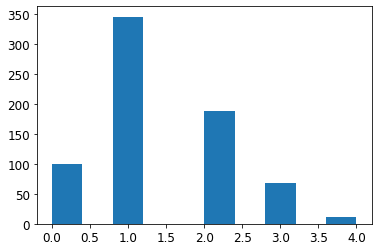

In [40]:
plt.hist(y_train_age_binned)

## Feature transformations

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

age_predictor_data_transform_pipeline = ColumnTransformer([
        ("numerical", numerical_pipeline, ['Fare', 'Parch', 'SibSp']),
        ("categorical", OneHotEncoder(), ['Pclass']),
    ])

In [42]:
age_predictor_data_transform_pipeline.get_feature_names

<bound method ColumnTransformer.get_feature_names of ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('numerical',
                                 Pipeline(memory=None,
                                          steps=[('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True))],
                                          verbose=False),
                                 ['Fare', 'Parch', 'SibSp']),
                                ('categorical',
                                 OneHotEncoder(categorical_features=None,
                                               categories=None, drop=None,
                                               dtype=<class 'numpy.float64'>,
                                    

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [44]:
## First fit with entire data
age_predictor_data_transform_pipeline.fit(
    concat(
        X_train.drop(['Age', 'Survived'] + drop_columns, axis="columns"),
        X_test.drop(['Age'] + drop_columns, axis="columns")
    )
)

## Then transform on the target (age not null)
X_train_age_transformed = age_predictor_data_transform_pipeline.transform(X_train_age)
X_test_age_transformed = age_predictor_data_transform_pipeline.transform(X_test_age)

/home/oonisim/conda/envs/jupyter-notebook/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## Training of age predictor random forest

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rnd_clf_age = RandomForestClassifier()
param_grid = [
    {
        'n_estimators': [i for i in range(100, 300, 40)],
        'max_leaf_nodes': [i for i in range(24, 64, 8)],
        'max_depth': [i for i in range(3, 6, 1)],
    }
]
grid_search_age = GridSearchCV(rnd_clf_age, param_grid, cv=3, verbose=3, n_jobs=-1)
grid_search_age.fit(X_train_age_transformed, y_train_age_binned)

grid_search_age.best_score_

Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   17.9s finished


0.5532212885154062

In [46]:
rf_age = grid_search_age.best_estimator_
print("GridSearchCV best parameters for RF is {}".format(grid_search_age.best_params_))

GridSearchCV best parameters for RF is {'max_depth': 4, 'max_leaf_nodes': 40, 'n_estimators': 100}


In [47]:
age_train_predicted = rf_age.predict(X_train_age_transformed)
age_train_predicted[:10]

array([1., 2., 1., 2., 1., 2., 0., 1., 1., 1.])

In [48]:
hoge = pd.DataFrame(
    X_test_age_transformed
)
hoge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 6 columns):
0    332 non-null float64
1    332 non-null float64
2    332 non-null float64
3    332 non-null float64
4    332 non-null float64
5    332 non-null float64
dtypes: float64(6)
memory usage: 15.7 KB


In [49]:
age_test_predicted = rf_age.predict(X_test_age_transformed)
age_test_predicted[:10]

array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])

## Age prediction performance

In [50]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_age_binned, age_train_predicted)

array([[ 47,  49,   4,   0,   0],
       [  6, 312,  28,   0,   0],
       [  7, 112,  69,   0,   0],
       [  0,  34,  34,   1,   0],
       [  0,   5,   6,   0,   0]])

In [51]:
from sklearn.metrics import accuracy_score
accuracy_rf = accuracy_score(y_train_age_binned, age_train_predicted)

from sklearn.metrics import precision_recall_fscore_support as score
precision_rf, recall_rf, fscore_rf, support_rf = score(y_train_age_binned, age_train_predicted)

import pandas as pd
data_rf = [
    np.append(["Accracy"], accuracy_rf),
    np.append(["Precision"], precision_rf),
    np.append(["Recall"], recall_rf),
    np.append(["F1"], fscore_rf),
    np.append(["Support"], support_rf)
]
pd.DataFrame(data_rf)

/home/oonisim/conda/envs/jupyter-notebook/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,0,1,2,3,4,5
0,Accracy,0.6008403361344538,None,None,None,None
1,Precision,0.7833333333333333,0.609375,0.48936170212765956,1.0,0.0
2,Recall,0.47,0.9017341040462428,0.3670212765957447,0.014492753623188406,0.0
3,F1,0.5874999999999999,0.7272727272727273,0.4194528875379939,0.02857142857142857,0.0
4,Support,100,346,188,69,11


In [52]:
X_train_age_to_predict = X_train[X_train['Age'].isnull()].drop(['Age', 'Survived'] + drop_columns, axis="columns")
X_train_age_to_predict.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
5,3,male,0,0,8.4583,Q
17,2,male,0,0,13.0000,S
19,3,female,0,0,7.2250,C
26,3,male,0,0,7.2250,C
28,3,female,0,0,7.8792,Q


In [53]:
X_test_age_to_predict = X_test[X_test['Age'].isnull()].drop(['Age'] + drop_columns, axis="columns")
X_test_age_to_predict.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
10,3,male,0,0,7.8958,S
22,1,female,0,0,31.6833,S
29,3,male,2,0,21.6792,C
33,3,female,1,2,23.4500,S
36,3,female,0,0,8.0500,S


In [54]:
X_train_age_to_predict_prepared = age_predictor_data_transform_pipeline.transform(X_train_age_to_predict)
X_train_age_to_predict_prepared.shape

(177, 6)

In [55]:
X_test_age_to_predict_prepared = age_predictor_data_transform_pipeline.transform(X_test_age_to_predict)
X_test_age_to_predict_prepared.shape

(86, 6)

In [56]:
train_age_binneed_predicted = rf_age.predict(X_train_age_to_predict_prepared)

In [57]:
test_age_binneed_predicted = rf_age.predict(X_test_age_to_predict_prepared)

In [58]:
X_train_prepared = X_train.copy()
X_train_prepared.loc[X_train['Age'].notnull(), 'Age'] = y_train_age_binned
X_train_prepared.loc[X_train['Age'].isnull(), 'Age'] = train_age_binneed_predicted

In [59]:
X_test_prepared = X_test.copy()
X_test_prepared.loc[X_test['Age'].notnull(), 'Age'] = y_test_age_binned
X_test_prepared.loc[X_test['Age'].isnull(), 'Age'] = test_age_binneed_predicted

# Survival predictor training

In [60]:
X_train_prepared = X_train_prepared.drop(['Survived'] + drop_columns, axis=1)
X_train_prepared.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,1.0,1,0,7.2500,S
1,1,female,2.0,1,0,71.2833,C
2,3,female,1.0,0,0,7.9250,S
3,1,female,2.0,1,0,53.1000,S
4,3,male,2.0,0,0,8.0500,S
5,3,male,1.0,0,0,8.4583,Q
6,1,male,3.0,0,0,51.8625,S
7,3,male,0.0,3,1,21.0750,S
8,3,female,1.0,0,2,11.1333,S
9,2,female,0.0,1,0,30.0708,C


In [61]:
X_test_prepared = X_test_prepared.drop(drop_columns, axis=1)
X_test_prepared.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,2.0,0,0,7.8292,Q
1,3,female,2.0,1,0,7.0000,S
2,2,male,3.0,0,0,9.6875,Q
3,3,male,1.0,0,0,8.6625,S
4,3,female,1.0,1,1,12.2875,S
5,3,male,0.0,0,0,9.2250,S
6,3,female,1.0,0,0,7.6292,Q
7,2,male,1.0,1,1,29.0000,S
8,3,female,1.0,0,0,7.2292,C
9,3,male,1.0,2,0,24.1500,S


In [62]:
X_train_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


## Imputation and Scaling

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([
        ("numerical", numerical_pipeline, numerical_columns),
        ("categorical", OneHotEncoder(), categorical_columns),
    ])

In [64]:
# Fit with entire data to apply the same scaling
full_pipeline.fit(concat(X_train_prepared, X_test_prepared))

X_train_transformed = full_pipeline.transform(X_train_prepared)
X_test_transformed = full_pipeline.transform(X_test_prepared)

full_pipeline.get_feature_names

<bound method ColumnTransformer.get_feature_names of ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('numerical',
                                 Pipeline(memory=None,
                                          steps=[('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True))],
                                          verbose=False),
                                 ['Age', 'Fare', 'SibSp', 'Parch']),
                                ('categorical',
                                 OneHotEncoder(categorical_features=None,
                                               categories=None, drop=None,
                                               dtype=<class 'numpy.float64'>,
                             

In [65]:
X_train_transformed.shape

(891, 12)

In [66]:
X_train_transformed

array([[-0.37997942, -0.50317336,  0.48128777, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.84211655,  0.7348101 ,  0.48128777, ...,  1.        ,
         0.        ,  0.        ],
       [-0.37997942, -0.4901233 , -0.47908676, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-1.6020754 , -0.18997176,  0.48128777, ...,  0.        ,
         0.        ,  1.        ],
       [-0.37997942, -0.06333778, -0.47908676, ...,  1.        ,
         0.        ,  0.        ],
       [-0.37997942, -0.49350665, -0.47908676, ...,  0.        ,
         1.        ,  0.        ]])

# Random Forest



In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rnd_clf = RandomForestClassifier()
param_grid = [
    {
        'n_estimators': [i for i in range(400, 600, 50)],
        'max_leaf_nodes': [i for i in range(32, 128, 4)],
        'max_depth': [i for i in range(5, 8, 1)],
    }
]
grid_search = GridSearchCV(rnd_clf, param_grid, cv=3, verbose=3, n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)
rf = grid_search.best_estimator_

print("GridSearchCV best parameters for RF is {}".format(grid_search.best_params_))

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   29.6s finished
/home/oonisim/conda/envs/jupyter-notebook/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV best parameters for RF is {'max_depth': 4, 'max_leaf_nodes': 100, 'n_estimators': 500}


In [79]:
grid_search.best_score_

0.813692480359147

GridSearchCV best parameters for RF is {'max_depth': 6, 'max_leaf_nodes': 40, 'n_estimators': 400}
grid_search.best_score_: 0.8226711560044894
Your submission scored 0.79904, which is an improvement of your previous score of 0.78947.
Rank 2068
<pre>
param_grid = [
    {
        'n_estimators': [i for i in range(400, 600, 50)],
        'max_leaf_nodes': [i for i in range(32, 128, 4)],
        'max_depth': [i for i in range(5, 8, 1)],
    }
]

0	1	2
0	Accracy	0.8518518518518519	None
1	Precision	0.8357487922705314	0.8888888888888888
2	Recall	0.9453551912568307	0.7017543859649122
3	F1	0.8871794871794872	0.7843137254901961
4	Support	549	342
</pre>

---
GridSearchCV best parameters for RF is {'max_depth': 7, 'max_leaf_nodes': 40, 'n_estimators': 400}
grid_search.best_score_: 0.8237934904601572
You advanced 6,240 places on the leaderboard! Your submission scored 0.78947,
Rank 4024, Score 0.78947

---
GridSearchCV best parameters for RF is {'max_depth': 11, 'max_leaf_nodes': 72, 'n_estimators': 600}
grid_search.best_score_: 0.8260381593714927
Your submission scored 0.73684, which is not an improvement of your best score. Keep trying!
<pre>
0	1	2
0	Accracy	0.9113355780022446	None
1	Precision	0.8996598639455783	0.933993399339934
2	Recall	0.9635701275045537	0.827485380116959
3	F1	0.93051890941073	0.8775193798449611
4	Support	549	342
</pre>

In [80]:
grid_search.best_params_

{'max_depth': 4, 'max_leaf_nodes': 100, 'n_estimators': 500}

In [81]:
y_train_pred_rf = rf.predict(X_train_transformed)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred_rf)

array([[509,  40],
       [114, 228]])

In [82]:
from sklearn.metrics import accuracy_score
accuracy_rf = accuracy_score(y_train, y_train_pred_rf)

from sklearn.metrics import precision_recall_fscore_support as score
precision_rf, recall_rf, fscore_rf, support_rf = score(y_train, y_train_pred_rf)

import pandas as pd
data_rf = [
    np.append(["Accracy"], accuracy_rf),
    np.append(["Precision"], precision_rf),
    np.append(["Recall"], recall_rf),
    np.append(["F1"], fscore_rf),
    np.append(["Support"], support_rf)
]
pd.DataFrame(data_rf)

,0,1,2
0,Accracy,0.8271604938271605,None
1,Precision,0.8170144462279294,0.8507462686567164
2,Recall,0.9271402550091075,0.6666666666666666
3,F1,0.8686006825938566,0.7475409836065574
4,Support,549,342


In [83]:
accuracy_rf

0.8271604938271605

# Prediction

In [84]:
X_test_transformed

array([[ 0.84211655, -0.49197544, -0.47908676, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.84211655, -0.50800672,  0.48128777, ...,  0.        ,
         0.        ,  1.        ],
       [ 2.06421253, -0.45604812, -0.47908676, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.84211655, -0.50317336, -0.47908676, ...,  0.        ,
         0.        ,  1.        ],
       [-0.37997942, -0.48770662, -0.47908676, ...,  0.        ,
         0.        ,  1.        ],
       [-1.6020754 , -0.21107807,  0.48128777, ...,  1.        ,
         0.        ,  0.        ]])

In [85]:
y_test_pred_rf = rf.predict(X_test_transformed)

In [86]:
y_test_pred_rf[:5]

array([0, 0, 0, 0, 1])

In [87]:
predictions = pd.DataFrame(
    {
        "PassengerId": X_test['PassengerId'].values,
        "Survived": y_test_pred_rf
    }
)

In [88]:
#np.savetxt("results/kaggle_titanic_pca_rf.csv", y_test_pred_rf, delimiter=",", fmt='%d')
predictions.to_csv("results/kaggle_titanic_pca_rf.csv", sep=',', encoding='utf-8', index=False)